## Section 1: Business Understanding
I analyze data from Kaggle with airbnb listings from Seattle and Boston.
The analysis will focus on the following matters: 
##### 1. Which city has the highest rates?
##### 2. Is the difference in rates same among different room types?
##### 3. What are the strongest predictors for price?

## Section 2 : Data Understanding
#### Importing necessary libraries

In [223]:
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

#### Gather Data

In [224]:
# Import listings
seattle_df = pd.read_csv('seattle_listings.csv')
boston_df = pd.read_csv("boston_listings.csv")

#### Concatenate data from both cities

In [225]:
seattle_df['city']='Seattle'
boston_df['city']='Boston'
listings = pd.concat([seattle_df, boston_df], ignore_index=True)

#### Checking Concatenation Dimensions

In [226]:
###Dimension of datasets
print("Boston has",boston_df.shape[0],"samples with", boston_df.shape[1],"total features.")
print("Seattle has",seattle_df.shape[0],"samples with", seattle_df.shape[1],"total features.")
print("Listings has",listings.shape[0],"samples with", listings.shape[1],"total features.")

Boston has 3585 samples with 95 total features.
Seattle has 3818 samples with 92 total features.
Listings has 7403 samples with 95 total features.


## Section 3 : Data Preparation

### Erase duplicate samples

In [227]:
# drop duplicates
ll = len(listings)
listings = listings.drop_duplicates()
print(f'Listings size before duplicate drop : {ll}, size after : {len(listings)}')

Listings size before duplicate drop : 7403, size after : 7403


### Check for null columns

In [228]:
# make price column the last
listings = listings[[c for c in listings if c not in ['price']] + ['price']]

# check for null values
listings.isnull().sum().sort_values()

id                                     0
city                                   0
state                                  0
smart_location                         0
country_code                           0
country                                0
latitude                               0
longitude                              0
room_type                              0
accommodates                           0
bed_type                               0
amenities                              0
guests_included                        0
extra_people                           0
neighbourhood_cleansed                 0
minimum_nights                         0
calendar_updated                       0
availability_30                        0
availability_60                        0
availability_90                        0
availability_365                       0
calendar_last_scraped                  0
number_of_reviews                      0
requires_license                       0
instant_bookable

In [229]:
# drop columns that have only null values
listings = listings.drop(['license'], axis=1)


In [230]:
#drop columns that we do not need for the analysis
drop = ['country','country_code', 'smart_location', 'state', 'market','host_response_time',
        'jurisdiction_names', 'host_location', 'street', 'listing_url', 'scrape_id', 'last_scraped', 
        'summary', 'space', 'description', 'neighborhood_overview','host_neighbourhood','neighbourhood',
        'notes', 'transit',  'thumbnail_url', 'medium_url', 'picture_url',
        'xl_picture_url', 'host_id', 'host_url', 'host_about', 'host_thumbnail_url', 'host_picture_url',
        'latitude', 'longitude', 'calendar_updated', 'calendar_last_scraped', 'name', 'host_name',
        'zipcode', 'experiences_offered','id']  

In [231]:

listings=listings.drop(drop,axis=1)

#### Checking neighbourhood columns to keep the more grouped one

In [232]:
listings[listings['city']=='Boston'][['neighbourhood_cleansed','neighbourhood_group_cleansed']]

,neighbourhood_cleansed,neighbourhood_group_cleansed
3818,Roslindale,NaN
3819,Roslindale,NaN
3820,Roslindale,NaN
3821,Roslindale,NaN
3822,Roslindale,NaN
...,...,...
7398,Charlestown,NaN
7399,Allston,NaN
7400,Charlestown,NaN
7401,Charlestown,NaN


In [233]:
listings[listings['city']=='Seattle'][['neighbourhood_cleansed','neighbourhood_group_cleansed']]

,neighbourhood_cleansed,neighbourhood_group_cleansed
0,West Queen Anne,Queen Anne
1,West Queen Anne,Queen Anne
2,West Queen Anne,Queen Anne
3,West Queen Anne,Queen Anne
4,West Queen Anne,Queen Anne
...,...,...
3813,Fremont,Other neighborhoods
3814,Portage Bay,Capitol Hill
3815,Rainier Beach,Rainier Valley
3816,Madison Park,Capitol Hill


In Boston the grouped feature is filled with Nan.
I will fill Nan values neighbourhood_cleansed feature
and keep the most grouped feature I have of each city , because my analysis is not on different neighborhoods

In [234]:
# Filling Nan values in the neighbourhood_group_cleansed column from neighbourhood_cleansed
listings['neighbourhood_group_cleansed']=listings['neighbourhood_group_cleansed'].fillna(listings['neighbourhood_cleansed'])

In [235]:
# Drop neighbourhood_cleansed feature
listings=listings.drop(['neighbourhood_cleansed'],axis=1)

In [236]:
# number of remaining columns
print(f"There are {len(listings.columns)} features left!")

There are 55 features left!


### Explore empty columns values
Bellow are the percent missing values per feature.
features have above 90% NaN values, we are going to drop these features.

In [237]:
# Calculating proportion of NA values in each column
prop_na = listings.isna().sum()/len(listings)
prop_na_05 = prop_na[prop_na > .05]
prop_na_05 = prop_na_05.sort_values(0, ascending=True).reset_index()


Plotting proportion of NA values for all columns where more than 5% is missing. 



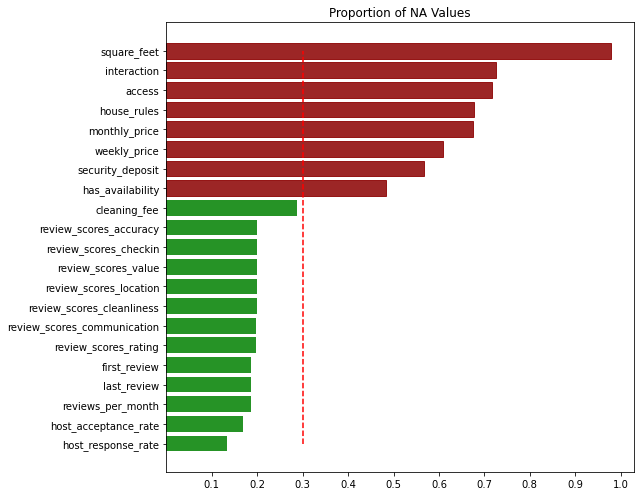

In [238]:
plt.figure(figsize=(9, 7))

barh = plt.barh(prop_na_05['index'], prop_na_05[0], alpha=0.85, color='green')
for i in range(8):
    i += 1
    barh[-i].set_color('darkred')

plt.title('Proportion of NA Values')
plt.vlines(x=.3, ymin=0, ymax=20, color='red', linestyles='dashed')
plt.xticks(np.arange(.1, 1.01, .1))

plt.tight_layout()

The 8 columns in red will be removed since they are missing > 30% of their values.


In [239]:
drop_cols = ['square_feet','interaction','access','house_rules', 'monthly_price', 'weekly_price',
                'security_deposit', 'has_availability']
listings = listings.drop(drop_cols, axis=1)


In [240]:
# number of remaining columns
print(f"There are {len(listings.columns)} columns left!")

There are 47 columns left!


### Explore Missing Data

In [241]:
listings.isna().sum().sort_values()/listings.shape[0]

minimum_nights                      0.000000
guests_included                     0.000000
extra_people                        0.000000
maximum_nights                      0.000000
availability_30                     0.000000
availability_60                     0.000000
availability_90                     0.000000
amenities                           0.000000
availability_365                    0.000000
requires_license                    0.000000
instant_bookable                    0.000000
cancellation_policy                 0.000000
require_guest_profile_picture       0.000000
require_guest_phone_verification    0.000000
calculated_host_listings_count      0.000000
number_of_reviews                   0.000000
bed_type                            0.000000
price                               0.000000
accommodates                        0.000000
room_type                           0.000000
is_location_exact                   0.000000
city                                0.000000
neighbourh

#### Date/Time Feature Engineering
Converting the date features to "days since" features so we have numerical values to work with.

In [242]:
"""
dates handling
we take the days from then until now
NaN cells where filled with 0 because they have none review
"""
date_feature=['host_since','last_review','first_review']
df = listings[date_feature]

today = pd.to_datetime('today')

# fill Nan with most common date

df['host_since']= pd.DatetimeIndex(df['host_since'])
most=df['host_since'].value_counts().index[0]
df['host_since'].fillna(most,inplace=True) 

for i in df:
    df[i]=df[i].apply(lambda x: pd.to_datetime(x, infer_datetime_format=True))
    df[i]=(today - df[i]).apply(lambda x: x.days)

#both of those features nan values are nan because there are not reviews for those samples

df['last_review'].fillna(0,inplace=True)
df['first_review'].fillna(0,inplace=True) 

#making sure everything is int type

for i in df:
    df[i]=df[i].apply(lambda x:int(x))

# parsing everything to listings df

for i in df:
    listings[i] = df[i]     

Filling missing data 

In [243]:
# filling missing data with most common

fill_most_common =['host_listings_count','beds','bedrooms','reviews_per_month','host_since','property_type'
                   ,'host_total_listings_count','host_has_profile_pic', 'host_identity_verified' ,'bathrooms',
                   'host_is_superhost']
df = listings[fill_most_common]


for i in df:
    most = df[i].value_counts().index[0] 
    df[i].fillna(most,inplace = True) 

In [244]:
# parsing everything to listings df

for i in df:
    listings[i] = df[i] 

In [245]:
# reviews_per_month filling missing values with 0.0 because they have no reviews

fill_with_zero =['reviews_per_month']
df = listings[fill_with_zero]


for i in df:
    most = df[i].value_counts().index[0] 
    df[i].fillna(0,inplace = True) 

In [246]:
# parsing everything to listings df

for i in df:
    listings[i] = df[i] 

In [247]:
listings.shape[0]

7403

## Explore the data types

In [248]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7403 entries, 0 to 7402
Data columns (total 47 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   host_since                        7403 non-null   int64  
 1   host_response_rate                6409 non-null   object 
 2   host_acceptance_rate              6159 non-null   object 
 3   host_is_superhost                 7403 non-null   object 
 4   host_listings_count               7403 non-null   float64
 5   host_total_listings_count         7403 non-null   float64
 6   host_verifications                7403 non-null   object 
 7   host_has_profile_pic              7403 non-null   object 
 8   host_identity_verified            7403 non-null   object 
 9   neighbourhood_group_cleansed      7403 non-null   object 
 10  city                              7403 non-null   object 
 11  is_location_exact                 7403 non-null   object 
 12  proper

### Explore categorical columns.

Convert some of these to numerical columns (i.e. prices and response rate)

Binarize the Binary/Boolean columns

host_verifications and amenities have multiple items

In [249]:
cat_df = listings.select_dtypes(include=['object', 'bool'])
cat_cols = listings.select_dtypes(include=['object', 'bool']).columns.values
num_df = listings.select_dtypes(include=['int64', 'float64'])
num_cols = listings.select_dtypes(include=['int64', 'float64']).columns.values

In [250]:
cat_df.head().transpose() 

,0,1,2,3,4
host_response_rate,96%,98%,67%,NaN,100%
host_acceptance_rate,100%,100%,100%,NaN,NaN
host_is_superhost,f,t,f,f,f
host_verifications,"['email', 'phone', 'reviews', 'kba']","['email', 'phone', 'facebook', 'linkedin', 're...","['email', 'phone', 'google', 'reviews', 'jumio']","['email', 'phone', 'facebook', 'reviews', 'jum...","['email', 'phone', 'facebook', 'reviews', 'kba']"
host_has_profile_pic,t,t,t,t,t
host_identity_verified,t,t,t,t,t
neighbourhood_group_cleansed,Queen Anne,Queen Anne,Queen Anne,Queen Anne,Queen Anne
city,Seattle,Seattle,Seattle,Seattle,Seattle
is_location_exact,t,t,t,t,t
property_type,Apartment,Apartment,House,Apartment,House


#### Recognizing features that needs to be turned from categoricals to numericals

In [251]:
cat_to_num = ['host_response_rate', 'price', 'cleaning_fee', 'extra_people']
prices = ['price', 'cleaning_fee', 'extra_people']

cat_to_num_df = cat_df[cat_to_num]
cat_to_num_df.head(2)

,host_response_rate,price,cleaning_fee,extra_people
0,96%,$85.00,NaN,$5.00
1,98%,$150.00,$40.00,$0.00


In [252]:
# Converting the response rate to integers
def repl(m): return m.group(1)

cat_to_num_df['host_response_rate'] = cat_to_num_df['host_response_rate'].str.replace(
    r'(\d+)%', repl).astype(float)

In [253]:
# Removing commas and dollar signs, then converting to float
for col in prices:
    cat_to_num_df[col] = cat_to_num_df[col].str.replace(
        '$', '').str.replace(',', '')
    cat_to_num_df[col] = cat_to_num_df[col].astype(float)

In [254]:
# Checking results
cat_to_num_df.head(1)

,host_response_rate,price,cleaning_fee,extra_people
0,96.0,85.0,NaN,5.0


In [255]:
# if not a cleaning fee . suppose 0
cat_to_num_df['cleaning_fee']=cat_to_num_df['cleaning_fee'].fillna(value=0.0)

In [256]:
cat_to_num_df.head(1)

,host_response_rate,price,cleaning_fee,extra_people
0,96.0,85.0,0.0,5.0


In [257]:
#adjusting properly the num_df and cat_df after the conversions
num_df = pd.concat([num_df, cat_to_num_df], axis=1)
num_cols = num_df.columns.values
cat_df = cat_df.drop(cat_to_num, axis=1)
cat_cols = cat_df.columns.values

### Binary Categorical

In [258]:
#recognize Binary columns
bi_cols = []
for col in cat_df.columns:
    if cat_df[col].nunique() <= 2:
        bi_cols.append(col)

In [259]:
cat_df[bi_cols].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,city,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,f,t,t,Seattle,t,f,f,f,f
1,t,t,t,Seattle,t,f,f,t,t
2,f,t,t,Seattle,t,f,f,f,f
3,f,t,t,Seattle,t,f,f,f,f
4,f,t,t,Seattle,t,f,f,f,f


In [260]:
#leave city as categorical
bi_cols.remove("city")

In [261]:
# get 1 , 0 in place of True, False
for col in bi_cols:
    cat_df[col] = cat_df[col].map({'f': 0, 't': 1})

In [262]:
# check result
cat_df[bi_cols].head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,is_location_exact,requires_license,instant_bookable,require_guest_profile_picture,require_guest_phone_verification
0,0,1,1,1,0,0,0,0
1,1,1,1,1,0,0,1,1
2,0,1,1,1,0,0,0,0
3,0,1,1,1,0,0,0,0
4,0,1,1,1,0,0,0,0


### Handle Multiple Values in One Column
host_verifications, 
amenities

In [263]:
cat_df.head().transpose()

,0,1,2,3,4
host_acceptance_rate,100%,100%,100%,NaN,NaN
host_is_superhost,0,1,0,0,0
host_verifications,"['email', 'phone', 'reviews', 'kba']","['email', 'phone', 'facebook', 'linkedin', 're...","['email', 'phone', 'google', 'reviews', 'jumio']","['email', 'phone', 'facebook', 'reviews', 'jum...","['email', 'phone', 'facebook', 'reviews', 'kba']"
host_has_profile_pic,1,1,1,1,1
host_identity_verified,1,1,1,1,1
neighbourhood_group_cleansed,Queen Anne,Queen Anne,Queen Anne,Queen Anne,Queen Anne
city,Seattle,Seattle,Seattle,Seattle,Seattle
is_location_exact,1,1,1,1,1
property_type,Apartment,Apartment,House,Apartment,House
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt


In [264]:
def striplist(l):
    """Strips every string of an array"""
    return([x.strip() for x in l])

In [265]:
# turn into lowercase and strip both features from symbols , [,],' and whitespaces
cat_df['host_verifications'] = cat_df['host_verifications'].str.replace('[', '').str.replace(']', '').str.replace("'",'').str.lower().str.split(',').apply(striplist)
cat_df['amenities'] = cat_df['amenities'].str.replace('{', '').str.replace('}','').str.replace('"', '').str.lower().str.split(',').apply(striplist)

#### Turn Multiple Values in Column to different features

In [266]:
# use Multilabelbinarizer to turn into different binary variables the distinct values of the two features
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
amenities_df = pd.DataFrame(mlb.fit_transform(
    cat_df['amenities']), columns=mlb.classes_, index=cat_df.index)

In [267]:
mlb = MultiLabelBinarizer()
host_verif_df = pd.DataFrame(mlb.fit_transform(
    cat_df['host_verifications']), columns=mlb.classes_, index=cat_df.index)

In [268]:
host_verif_df = host_verif_df.drop(axis=1, labels=[''])
amenities_df = amenities_df.drop(axis=1, labels=[''])

In [269]:
# drop previous multi valued features
cat_df = cat_df.drop(['host_verifications', 'amenities'], axis=1)

In [270]:
#Concatenating the DataFrames together.

cat_df = pd.concat([cat_df, amenities_df, host_verif_df], axis=1)
cat_cols = cat_df.columns.values

In [271]:
# checking the result
cat_df.head().transpose()


,0,1,2,3,4
host_acceptance_rate,100%,100%,100%,NaN,NaN
host_is_superhost,0,1,0,0,0
host_has_profile_pic,1,1,1,1,1
host_identity_verified,1,1,1,1,1
neighbourhood_group_cleansed,Queen Anne,Queen Anne,Queen Anne,Queen Anne,Queen Anne
city,Seattle,Seattle,Seattle,Seattle,Seattle
is_location_exact,1,1,1,1,1
property_type,Apartment,Apartment,House,Apartment,House
room_type,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt,Entire home/apt
bed_type,Real Bed,Real Bed,Real Bed,Real Bed,Real Bed


#### Concatenate numerical and categorical dfs back to one listings df

In [272]:
listings = pd.concat([num_df, cat_df], axis=1)

In [273]:
listings.head().transpose()

,0,1,2,3,4
host_since,3875,3315,2839,3057,3765
host_listings_count,3,6,2,1,2
host_total_listings_count,3,6,2,1,2
accommodates,4,4,11,3,6
bathrooms,1,1,4.5,1,2
bedrooms,1,1,5,0,3
beds,1,1,7,2,3
guests_included,2,1,10,1,6
minimum_nights,1,2,4,1,1
maximum_nights,365,90,30,1125,1125


### Checking rows with many NaN values

In [274]:
listings['sum_na_row'] = listings.isna().sum(axis=1)

In [275]:
temp = listings[listings['sum_na_row'] >= 9].isna().any().reset_index()
na_cols = temp[temp[0] == True]['index'].values
listings[listings['sum_na_row'] >= 9][na_cols].transpose()

,3,18,23,53,58,70,85,87,98,118,...,7256,7259,7261,7291,7353,7379,7380,7381,7395,7397
review_scores_rating,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_accuracy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_cleanliness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_checkin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_communication,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_location,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_scores_value,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_response_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_acceptance_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Filling Nan review values

NA values related to reviews are most likely missing because this particular unit does not have any reviews. 
This could be useful information. I'll encode these values with the mean of the values.


I used the mean, cause I tried not to change the avg review rating of the existings reviews

In [276]:
review_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
               'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
               'review_scores_value','host_response_rate','host_acceptance_rate']

In [277]:
listings['host_acceptance_rate'] = listings['host_acceptance_rate'].astype(str).str.rstrip('%').astype('float')

In [278]:
listings[review_cols].head(200)

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_response_rate,host_acceptance_rate
0,95.0,10.0,10.0,10.0,10.0,9.0,10.0,96.0,100.0
1,96.0,10.0,10.0,10.0,10.0,10.0,10.0,98.0,100.0
2,97.0,10.0,10.0,10.0,10.0,10.0,10.0,67.0,100.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92.0,9.0,9.0,10.0,10.0,9.0,9.0,100.0,NaN
5,95.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN
6,99.0,10.0,10.0,10.0,10.0,10.0,10.0,100.0,100.0
7,97.0,10.0,10.0,10.0,10.0,9.0,10.0,100.0,100.0
8,97.0,10.0,9.0,10.0,9.0,10.0,10.0,NaN,100.0
9,97.0,10.0,10.0,10.0,10.0,10.0,9.0,98.0,100.0


In [279]:
listings[review_cols].mean(axis=0)

review_scores_rating           93.316002
review_scores_accuracy          9.540865
review_scores_cleanliness       9.417229
review_scores_checkin           9.721181
review_scores_communication     9.733569
review_scores_location          9.518056
review_scores_value             9.319777
host_response_rate             94.936496
host_acceptance_rate           91.981653
dtype: float64

In [280]:
listings[review_cols] = listings[review_cols].fillna(value=listings[review_cols].mean(axis=0))

In [281]:
listings[review_cols].head(200)

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_response_rate,host_acceptance_rate
0,95.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,96.000000,100.000000
1,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,98.000000,100.000000
2,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,67.000000,100.000000
3,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,94.936496,91.981653
4,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,100.000000,91.981653
5,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,94.936496,91.981653
6,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,100.000000
7,97.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,100.000000,100.000000
8,97.000000,10.000000,9.000000,10.000000,9.000000,10.000000,10.000000,94.936496,100.000000
9,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,98.000000,100.000000


In [282]:
# checking the result
listings.isna().sum()

host_since                                    0
host_listings_count                           0
host_total_listings_count                     0
accommodates                                  0
bathrooms                                     0
bedrooms                                      0
beds                                          0
guests_included                               0
minimum_nights                                0
maximum_nights                                0
availability_30                               0
availability_60                               0
availability_90                               0
availability_365                              0
number_of_reviews                             0
first_review                                  0
last_review                                   0
review_scores_rating                          0
review_scores_accuracy                        0
review_scores_cleanliness                     0
review_scores_checkin                   

In [283]:
#dropping the aggregate column and creating a new df for the statistical analysis
clean_df=listings.drop(['sum_na_row'], axis=1)

##### I will insert a new feature price_per_accomodate to use in the analysis

In [285]:
clean_df['price_per_accomodate']=clean_df['price']/clean_df['accommodates']

## Section 4: Data Modelling 
##### Turn categorical columns into dummies

In [284]:
# creating a new ml_df with the cleaned data for use in the ml analysis
ml_df=clean_df

In [77]:
ml_df['city'] = ml_df['city'].map({'Seattle':0,'Boston':1})

In [78]:
cat_columns = list(ml_df.select_dtypes(include=['object']).columns)
    
for col in  cat_columns:
    ml_df = pd.concat([ml_df.drop(col, axis=1), pd.get_dummies(ml_df[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=True)], axis=1)


In [79]:
#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics


In [80]:
price_df=ml_df.drop(['price'],axis=1)

In [81]:
# make features and target arrays

y = price_df['price_per_accomodate']
X = price_df.drop(['price_per_accomodate'], axis=1)

# train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [82]:
#prepare train and test datasets for modelling
TEST_SIZE = 0.3
RAND_STATE = 42

X = price_df.drop(columns = 'price_per_accomodate')
y = price_df[['price_per_accomodate']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [83]:
#train RF regressor model
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=RAND_STATE, 
                               n_jobs=-1)
forest.fit(X_train, y_train.squeeze())

#calculate scores for the model
y_train_preds = forest.predict(X_train)
y_test_preds = forest.predict(X_test)

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 273.500, test: 696.888
Random Forest R^2 train: 0.872, test: 0.288


## Section 5: Evaluate the Results

### Question 1. Which city has the highest rates?

##### First I will use the Price variable and then the Price_per_accommodate

In [66]:
#find minimum, maximum and average price for listing
min_price = clean_df.groupby('city')['price'].min()
max_price = clean_df.groupby('city')['price'].max()
mean_price = clean_df.groupby('city')['price'].mean()

print('Minimum price in Seattle per listing is %d$.' % (min_price['Seattle']))
print('Minimum price in Boston per listing is %d$.' % (min_price['Boston']))
print('Maximum price in Seattle per listing is %d$' % (max_price['Seattle']))
print('Maximum price in Boston per listing is %d$' % (max_price['Boston']))
print('Average price in Seattle per listing is %d$.' % (mean_price['Seattle']))
print('Average price in Boston per listing is %d$.' % (mean_price['Boston']))

Minimum price in Seattle per listing is 20$.
Minimum price in Boston per listing is 10$.
Maximum price in Seattle per listing is 1000$
Maximum price in Boston per listing is 4000$
Average price in Seattle per listing is 127$.
Average price in Boston per listing is 173$.


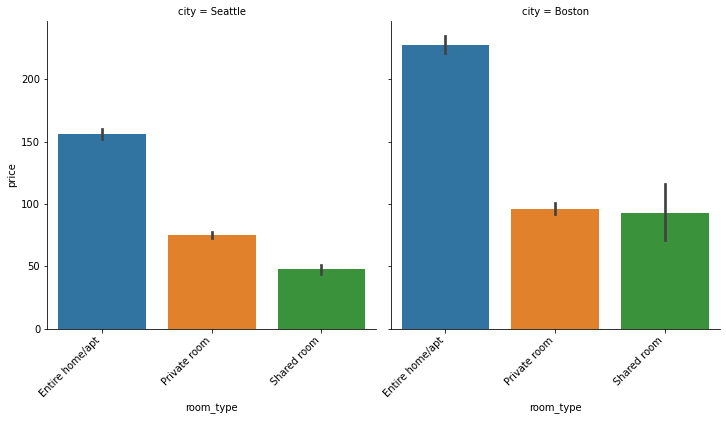

In [67]:
cpsl=sns.catplot(x='room_type', y='price',col='city', kind='bar', data=clean_df)
cpsl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_room_twocities.png')

The above results show that Boston is higher rated

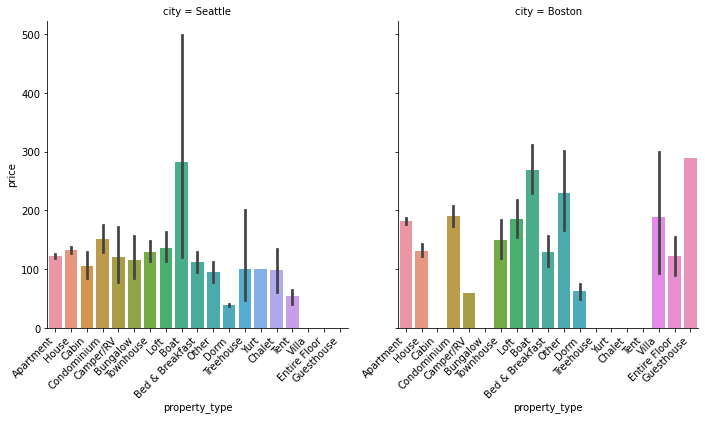

In [68]:
cpsl=sns.catplot(x='property_type', y='price',col='city', kind='bar', data=clean_df)
cpsl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_type_twocities.png')

Also here the same, with the exxception of boat and Camper/RV properies

##### Results using the "price" variable
From above analysis it is clear that Boston is higher rated than Seattle, almost in all categories of room types and property types. Also there are some differences in the properties available in each city, with Boston offering the most expensive airbnb solutions 

##### Same analysis with price per accomodate

In [70]:
#find minimum, maximum and average price for listing
min_price = clean_df.groupby('city')['price_per_accomodate'].min()
max_price = clean_df.groupby('city')['price_per_accomodate'].max()
mean_price = clean_df.groupby('city')['price_per_accomodate'].mean()

print('Minimum price per accomodate in Seattle per listing is %d$.' % (min_price['Seattle']))
print('Minimum price per accomodate in Boston per listing is %d$.' % (min_price['Boston']))
print('Maximum price per accomodate in Seattle per listing is %d$' % (max_price['Seattle']))
print('Maximum price per accomodate in Boston per listing is %d$' % (max_price['Boston']))
print('Average price per accomodate in Seattle per listing is %d$.' % (mean_price['Seattle']))
print('Average price per accomodate in Boston per listing is %d$.' % (mean_price['Boston']))

Minimum price per accomodate in Seattle per listing is 4$.
Minimum price per accomodate in Boston per listing is 5$.
Maximum price per accomodate in Seattle per listing is 275$
Maximum price per accomodate in Boston per listing is 1372$
Average price per accomodate in Seattle per listing is 41$.
Average price per accomodate in Boston per listing is 62$.


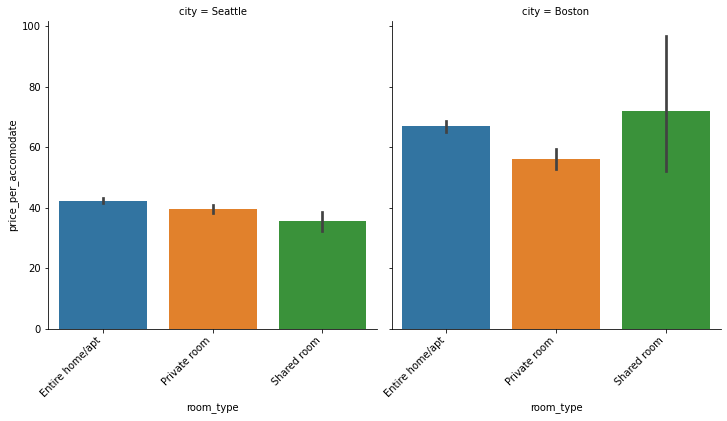

In [71]:
cpsl=sns.catplot(x='room_type', y='price_per_accomodate',col='city', kind='bar', data=clean_df)
cpsl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_per_accomodate_room_twocities.png')

Same results

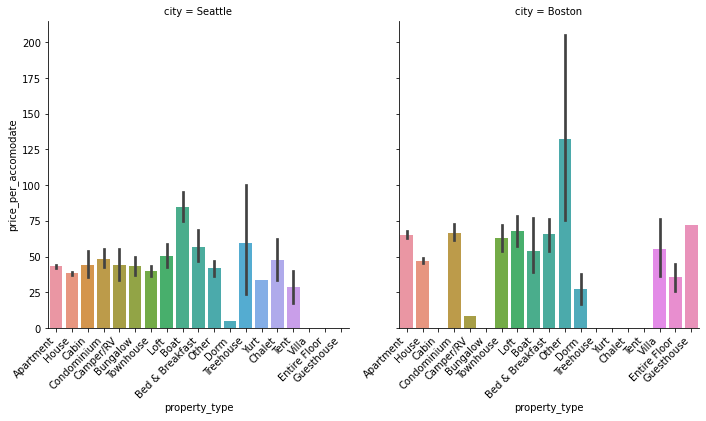

In [72]:
cpsl=sns.catplot(x='property_type', y='price_per_accomodate',col='city', kind='bar', data=clean_df)
cpsl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_per_accomodate_type_twocities.png')

Same results

##### Results using the "price_per_accommodation" variable
From above analysis the same results are with the new variable


### Question 2. Is the difference in rates same among different room types?

#### We used the "price per accommodate" variable to examine the difference in price n response to the number of beds, bathrooms, bedrooms and accommodates

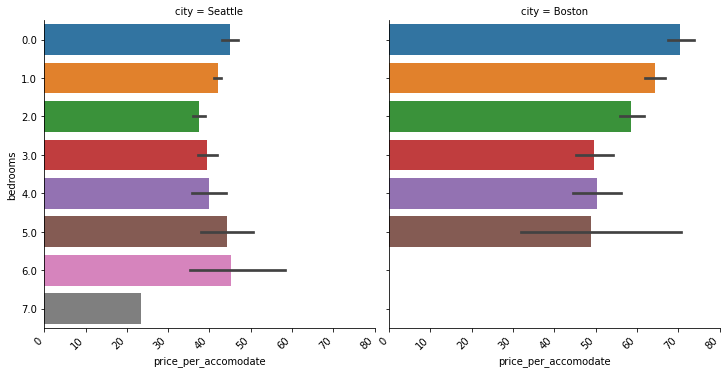

In [76]:
cbebl=sns.catplot(x='price_per_accomodate', y='bedrooms',col='city', orient = 'h', kind='bar',data=clean_df)
cbebl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_per_accomodate_bedrooms_twocities.png')

Boston airbnbs are in all categories higher rated , but seem to follow a different patern than Seattle. The difference between the two cities seems to narrow down as the # of bedrooms raises. Of course the data can't give as a clear view in this aspect. 

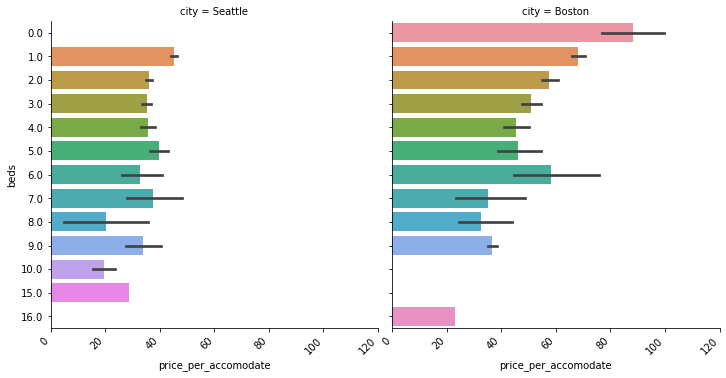

In [73]:
cbsl=sns.catplot(x='price_per_accomodate', y='beds',col='city', orient ='h', kind='bar',data=clean_df)
cbsl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_per_accomodate_beds_twocities.png')

Also here the prices are significantly higher in Boston and an approximation between thw two cities is in properties with 9 beds

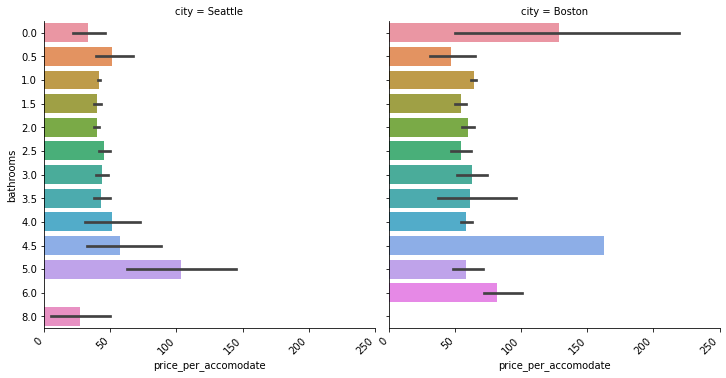

In [74]:
cbasl=sns.catplot(x='price_per_accomodate', y='bathrooms', kind='bar',col='city', orient = 'h', data=clean_df)
cbasl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_per_accomodate_bathrooms_twocities.png')

Also in response to the # of bathrooms,we have the same results , with Seattle going above Boston in properties with 5 bathrooms

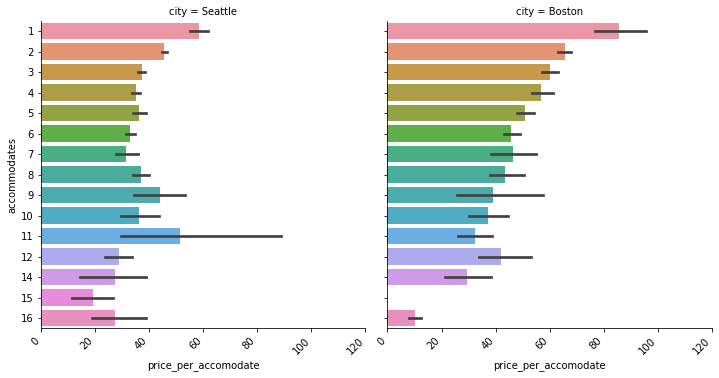

In [75]:
casl=sns.catplot(x='price_per_accomodate', y='accommodates',col='city', orient = 'h', kind='bar',data=clean_df)
casl.set_xticklabels(rotation=45, horizontalalignment='right')
plt.savefig('price_per_accomodate_accomodates_twocities.png')

Same results here , the prices come close in bigger properties. 


### Question 3. What are the strongest predictors for price?

In [289]:
# Fitting scores

print('Random Forest MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest MSE train: 273.500, test: 696.888
Random Forest R^2 train: 0.872, test: 0.288


The scoring is poor, maybe some more investigation in cleaning the data is needed

In [84]:
#Actual Vs Predicted for Linear Regression
lr_pred_df = pd.DataFrame({
        'actual_values': np.array(y_test).flatten(),
        'predicted_values': y_test_preds.flatten()}).head(20)

print(lr_pred_df.head(5))

   actual_values  predicted_values
0     100.000000         85.492662
1      51.666667         44.805571
2      49.500000         53.465000
3      66.333333         64.154833
4      40.625000         47.617810


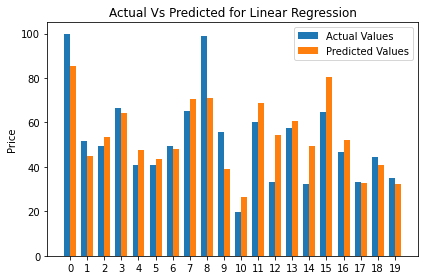

In [85]:
x = lr_pred_df.index
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, lr_pred_df.actual_values, width, label='Actual Values')
rects2 = ax.bar(x + width/2, lr_pred_df.predicted_values, width, label='Predicted Values')
ax.set_ylabel('Price')
ax.set_title('Actual Vs Predicted for Linear Regression')
ax.set_xticks(x)
ax.legend()
fig.tight_layout()
plt.savefig('actualVSpredict.png')
plt.show()

We get a nice approximation in the prices

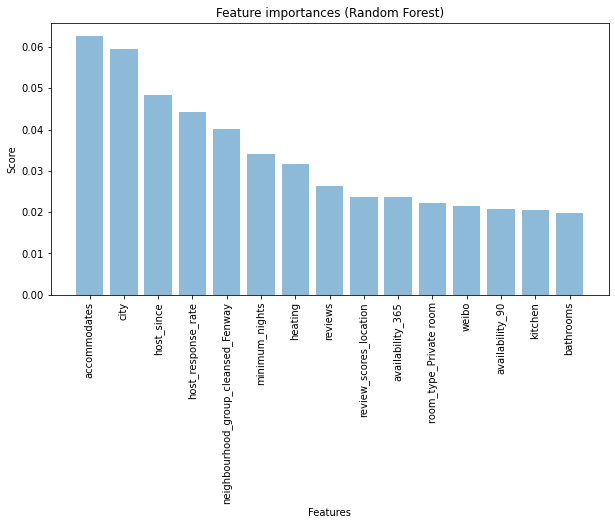

In [86]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, forest.feature_importances_), key=lambda x: x[1] * -1)
forest_feature_importances = pd.DataFrame(values, columns = headers)
forest_feature_importances = forest_feature_importances.sort_values(by = ['score'], ascending = False)

features = forest_feature_importances['name'][:15]
y_pos = np.arange(len(features))
scores = forest_feature_importances['score'][:15]

#plot feature importances
plt.figure(figsize=(10,5))
plt.bar(y_pos, scores, align='center', alpha=0.5)
plt.xticks(y_pos, features, rotation=90)
 
plt.ylabel('Score')
plt.xlabel('Features')
plt.title('Feature importances (Random Forest)')

plt.savefig('feature importances RF.png')
 
plt.show()

#### Results of the price prediction model
the model has low fitting scores but it manages to get a nice approximation in the prices. So I suppose that it is close in quessing the strongest predictors for price.
The results also seem reasonable to include the city , the neibohood, the accommodates, the reviews, the host details.